# Industry Classification -- (IN PROGRESS)
### Multilabel Classification Algorithm (NLP) for Categorizing Database of CrunchBase Companies into 87 Distinct Industries

Holden Bruce

In [1]:
#import the training data csv
import pandas as pd
TrainingData = pd.read_csv('TrainingData.csv')
TrainingData.head()
TrainingData.shape

(1130, 7)

In [2]:
#get rid of any null values for the descriptions column
#we are using the descriptions to feed our nlp algo
TrainingData = TrainingData[pd.notnull(TrainingData['CB Description'])]
TrainingData.shape
TrainingData.info()
TrainingData = TrainingData.drop_duplicates(subset=['id']).reset_index(drop=True)
TrainingData = TrainingData.dropna(subset=['CB Description']).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 0 to 1112
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              757 non-null    object
 1   name            757 non-null    object
 2   url             756 non-null    object
 3   CB Industries   757 non-null    object
 4   CB Description  757 non-null    object
 5   Keywords        651 non-null    object
 6   industry        757 non-null    object
dtypes: object(7)
memory usage: 47.3+ KB


In [3]:
#we are focusing on the descriptions column to predict the industry
col = ['CB Description', 'industry']
TrainingData_pred = TrainingData[col]
TrainingData_pred.columns
TrainingData_pred['industry'].unique()

array(['SAAS - Finance/HR - Accounting', 'SAAS - Travel Management',
       'SAAS - Sales - CRM', 'SAAS - Fitness', 'Retail - Box Store',
       'SAAS - Marketing Tech - Marketing Automation', 'Automotive',
       'Manufacturing', 'Utilities', 'Energy', 'Food Services',
       'Financial Services', 'Telecommunications', 'Transportation',
       'SAAS - Sales - AI/Sales Intelligence',
       'Tech - Internet - C2C Marketplace', 'Carbon Measurement & Mgmt',
       'SAAS - Contractor Engagement', 'SAAS - Payroll',
       'SAAS - Customer Service', 'SAAS - Finance/HR - Human Resources',
       'SAAS - eCommerce', 'Retail - eCommerce', 'SAAS - EdTech',
       'Computer Software', 'Educational Publishing', 'SAAS - Feedback',
       'SAAS - Marketing Tech - Event Management',
       'SAAS - Finance/HR - Payroll', 'Real Estate', 'Cleaning Services',
       'Tech - Internet - Gig Economy', 'Large Associations', 'Airline',
       'Software', 'Banking', 'Shipping', 'Insurance', 'Market Research',

In [7]:

# ##jump ahead now

# #add column names 
# TrainingData_pred.columns = ['CB_Description', 'industry']
# TrainingData_pred['industry_id'] = TrainingData_pred['industry'].factorize()[0]
# TrainingData_pred

# from io import StringIO
# industry_id_df = df[['industry', 'industry_id']].drop_duplicates().sort_values('industry_id')
# industry_id_df 
# industry_to_id = dict(industry_id_df.values)
# id_to_industry = dict(industry_id_df[['industry_id', 'industry']].values)
# df.head()


# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(8,6))
# df.groupby('industry').CB_Description.count().plot.bar(ylim=0)
# plt.show()
# ## this is really imbalanced


# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
# features = tfidf.fit_transform(df.CB_Description).toarray()
# labels = df.industry_id
# features.shape # (757, 363)


# from sklearn.feature_selection import chi2
# import numpy as np
# N = 2
# for industry, industry_id in sorted(industry_to_id.items()):
#     features_chi2 = chi2(features, labels)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(industry))
#     print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


# df
# desc = df['CB_Description']
# ind = df['CB Industries']

# [v for v in ind if len(v.split(", ")) == 1]
# df = df[pd.notnull(df['CB Industries'])]
# df.shape
# ind
# ind.shape
# df.shape

The bigrams output was so off, descriptions that were obviously coming from Event Planning were showing up in Airlines, and vocab for Airlines were showing up in Utilities...it just didn’t make sense. My guess was that the issue here had to do with there being only ~750 companies to choose from in the list, not nearly enough to train a reliable model. 


One solution I thought of would be to look at the entire list (not the list of 1000 that was manually done) and create a training dataset with companies that had only one or two entries in their CB Industries column. If there is only one, then do a direct comparison to the Industry Taxonomy column and assign that to the new ‘industry’ column for that company. 


If there were two potential industries in the column, write a little function that checks whether (1) that word exists anywhere in the Industry Taxonomy and (2) whether it is a unique word -- SAAS and Tech are used many times in many different industry classifications but something like “CRM” or Gig should set it apart somehow

In [8]:
#load full database excel
df = pd.read_excel('IndustryClassificationData.xlsx')
df.head()
df.shape

(46458, 7)

In [9]:
#get rid of all companies that have nulls in the CB Industries column
df = df[pd.notnull(df['CB Industries'])]
df.shape #(45979, 7)

(45979, 7)

In [73]:
# for loop to extract companies that have less than 2 industries assigned
# to their CB Industries column:
def find_companies(dataframe, column, num_ind):

    counter = 0
    ind_sub_2 = []
    #loop through each company in that column
    for company in df[column]:
        #turn company to string
        company = str(company)
        #if there are only one listed industry for the company
        
        #this only splits on commas
        # split_inds = company.split(", ") 
        
        #use regex to split on both ',' and ';'
        import re
        split_inds = re.split('; |,', company)
        
        #num_ind determines how many industries are present in the CB Industries column
        if len(split_inds) == num_ind and split_inds[0]!='nan':
            counter+=1
            ind_sub_2.append(split_inds)
        
    return ind_sub_2

ind_sub_2 = find_companies(df, 'CB Industries', 1)

#double checking to make sure the length is the same as the
#counter, which it is, so we're good    
len(ind_sub_2)

1945

Now that I have a list of the industries where only 1 or 2 industry categories were assigned by crunchbase, I can do some analysis on the list to see if there are any trends.

In [14]:
#put all of the words into one large string
inds_raw = ''
for company in ind_sub_2:
    # get rid of the (ERP) acronym for Enterprise Resource Planning
    if '(ERP)' in company[0]:
        company = company[0].replace("(ERP)", "")
        
    #replace the whitespace with an underscore so that i can analyze
    #the pairs of words (like "Social Media") as one industry instead of 
    #as two separate words
    company = company[0].replace(" ", "_")
        
    inds_raw += company + " "

inds_raw

'Search_Engine Search_Engine Search_Engine Social_Media Recruiting Marketing_Automation Social_Media Social_Media Search_Engine Search_Engine Human_Resources Hardware Recruiting Human_Resources Customer_Service Hardware Recruiting Recruiting Recruiting Hardware Search_Engine EdTech Search_Engine EdTech Recruiting Event_Management Event_Management Accounting Accounting Human_Resources Accounting Accounting Accounting Search_Engine Accounting Customer_Service Payments Hardware Human_Resources Accounting Hardware Human_Resources Social_Media CRM Search_Engine Hardware Human_Resources Event_Management Human_Resources Human_Resources Email_Marketing Hardware Hardware Human_Resources Event_Management Recruiting Hardware Search_Engine Event_Management Human_Resources Accounting Accounting Human_Resources Hardware Search_Engine Hardware Accounting Event_Management Search_Engine Email_Marketing Customer_Service Customer_Service Human_Resources Customer_Service Accounting Human_Resources Human_R

In [16]:
# Frequency Distribution
import nltk
text = nltk.word_tokenize(inds_raw)
fdist = nltk.FreqDist(text) #this returns all of the words and their number of occurences
list(fdist)

['Human_Resources',
 'Search_Engine',
 'Hardware',
 'Accounting',
 'Recruiting',
 'Social_Media',
 'Event_Management',
 'Payments',
 'Customer_Service',
 'EdTech',
 'Email_Marketing',
 'Marketing_Automation',
 'Point_of_Sale',
 'CRM',
 'E',
 'E-Commerce_Platforms',
 'Software',
 'Sales_Automation',
 'E-Signature',
 'Uploaded']

In [17]:
# FreqDist(text).keys() #would return list of all of the distinct words
FreqDist(text).keys() 

dict_keys(['Search_Engine', 'Social_Media', 'Recruiting', 'Marketing_Automation', 'Human_Resources', 'Hardware', 'Customer_Service', 'EdTech', 'Event_Management', 'Accounting', 'Payments', 'CRM', 'Email_Marketing', 'Software', 'Point_of_Sale', 'E', 'E-Commerce_Platforms', 'Sales_Automation', 'Uploaded', 'E-Signature'])

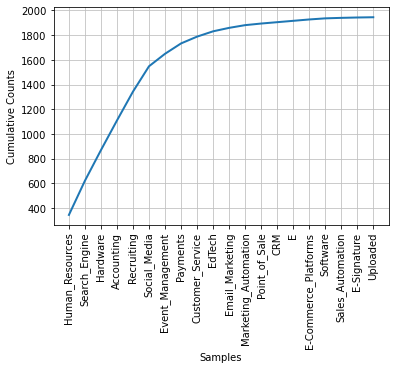

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [18]:
# this plots a cumulative frequency plot of the 50 most used words 
fdist.plot(50, cumulative=True)

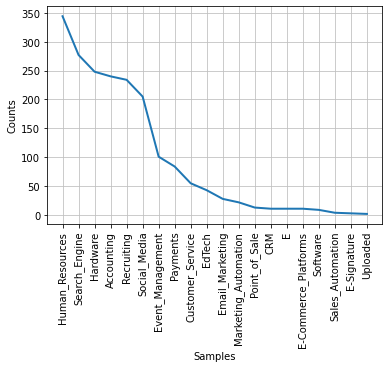

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
# this plots a regular plot of the most used words, showing word count
fdist.plot(50)

### Note 
I need to get rid of ( ERP ) because that was meant to just be an explained abreviation of Enterprise Resource Planning 

In [21]:
#loading in the list of 86 CrunchBase industries 
indtax = pd.read_csv('IndustryTaxonomy.csv')

In [22]:
#quick loop to see if any of the industry descriptions from ind_sub_2
#exactly match the list from the IndustryTaxonomy.csv list that hold
#86 different industry names defined by CrunchBase
for company in ind_sub_2:
    if company[0] in indtax:
        print(company[0])
#there are no direct matches

Ok, now I'm at the point where I have a list of 1945 companies that only have one industry associated with them from crunchbase. I could use this as my new training set but I could also look at companies with two industry classifications and see if I can extract any useful information from that, with the goal of making my training set larger than the 2k I'm currently working with

Regardless, I will need to reformulate some of the code above here to copy not only the industry column but also the cb description so that I can run some nltk analysis on the descriptions and begin making predictions with the training set I have.

### Goal:
Return dataframe (7 columns) where only companies in the dataframe are those that have only one industry #in the CB Industries column

In [24]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
# this is how to use split with pandas series
df['CB Industries'].head().str.split(pat = ",")[0]

['CRM',
 ' Customer Service',
 ' E-Commerce',
 ' Information Technology',
 ' Internet',
 ' Messaging',
 ' Sales',
 ' Software',
 ' Telecommunications']

In [25]:
#now save that reduced thing down to a new dataframe
df_reduced = df[df['CB Industries'].apply(lambda x: len(x.split(',')) < 2)]

In [26]:
df_reduced.shape # (1947, 7)

(1947, 7)

In [28]:
#assign the CB Industry to the 'industry' column
df_reduced['industry'] = df_reduced['CB Industries']
df_reduced = df_reduced.drop_duplicates(subset=['id']).reset_index(drop=True)
df_reduced = df_reduced.dropna(subset=['CB Description']).reset_index(drop=True)
df_reduced

,id,name,url,CB Industries,CB Description,Keywords,industry
0,35191-accounts,1001talents,https://www.1001talents.com,Search Engine,1001talents is an executive search firm.,NaN,Search Engine
1,13451-accounts,192.com,https://www.192.com,Search Engine,192.com is an innovative UK directory site. Se...,"people, search, businesses, places, directory,...",Search Engine
2,13295-accounts,20,https://www.020.co.uk/,Search Engine,020 is a search engine directory in the London.,"london, option, search, engine, directory, lis...",Search Engine
3,35343-accounts,225AM,https://225am.com,Social Media,225AM is the developer and retailer of platfor...,NaN,Social Media
4,13727-accounts,360Leaders,https://360leaders.com,Recruiting,360Leaders is an executive search and developm...,"executive, search, technology, clients, talent...",Recruiting
...,...,...,...,...,...,...,...
1938,203635-accounts,Zodiak Rights,https://www.zodiakrights.com,Social Media,Zodiak Rights represents a catalogue of over 2...,NaN,Social Media
1939,203663-accounts,Zoha Zaman Kabir Rashid & Co.,https://zzkrca.com,Accounting,Zoha Zaman Kabir Rashid & Co. is an independen...,"firms, services, chartered, accountants, indep...",Accounting
1940,203955-accounts,ZUMA Press,https://zumapress.com,Social Media,ZUMA Press is a photography company providing ...,"american, actress, actor, singer, california, ...",Social Media
1941,203979-accounts,ZuPush,https://www.zupush.com,Social Media,ZuPush.com - Social Selling As Service,NaN,Social Media


# Concatenate
Concatenate the two datasets to make a larger training set.

Now lets see if there are any companies from the original TrainingData.csv that we can also use here to make our training set bigger. To do this, I will simply concatenate the two pandas dataframes and then drop the duplicates based on the index in the first column 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html


In [29]:
df_train = pd.concat([df_reduced,TrainingData]).drop_duplicates(subset=['id']).reset_index(drop=True)
df_train.shape #(2704, 7)
df_train = df_train.dropna(subset=['CB Description']).reset_index(drop=True)

In [30]:
#get rid of whitespace 
df_train['industry'] = [w.strip() for w in df_train['industry']]
import re
df_train['industry'] = [re.sub('\s+',' ',w) for w in df_train['industry']]

In [31]:
df_train.shape #(2700, 7), we just dropped 377 companies that had nan in their description

(2700, 7)

Awesome! After combining the two datasets and dropping the duplicates, I am left with a new training set that is over twice as large as the original one. Hopefully this helps at least a little bit in making my predictions better. It probably won't, however, and I'll end up needing to increase the size of the training set even more.

### Note:
One thing I noticed right away is the descripency between how the TrainingData labeled industries and how CrunchBase labeled industries. There are examples like "Point of Sale" from the CB list and "SAAS - Point of Sale" from the TrainingData I got from Paolo. I will need to combine these types of duplicates.

In [34]:
############
###attempting to fix labeling issue
############

# logic: if first in other and second larger than first and 'SAAS' not in first:
# df_reduced,TrainingData

# df_train is concat of df_reduced and TrainingData
for first in range(len(df_reduced)): #loop through length of df_reduced
    #loop through length of TrainingData starting where df_reduced left off
    for other in range(len(df_reduced),len(df_reduced)+len(TrainingData)): 
        #if value from df_train[first] is in df_train[other] (like 'Point of Sale' in 'SAAS - Point of Sale') AND the first thing is smaller than the other thing AND 'SAAS' is not in the first thing, then...
        if df_train['industry'][first] in df_train['industry'][other] and len(df_train['industry'][other])>len(df_train['industry'][first]) and 'SAAS' not in df_train['industry'][first]: 
            #overwrite the df_train['industry'][first] value with the value of the 'other' 
            df_train['industry'][first] = df_train['industry'][other]
            
####### 
## end of fixing label issue
####### 

Now that I have fixed that, I will loop through CB Industries column and create a large string of all the words used so that I can do some analyses on those words.

# I STILL NEED TO DO THIS

In [40]:
#put all of the words into one large string
#train_str = ''
#for company in df_train['industry']:
    #print(company)
    #if 'Point of Sale' in company:
    # get rid of the (ERP) acronym for Enterprise Resource Planning
#    if '(ERP)' in company[0]:
        #company = company[0].replace("(ERP)", "")
        
    #replace the whitespace with an underscore so that i can analyze
    #the pairs of words (like "Social Media") as one industry instead of 
    #as two separate words
 #   company = company[0].replace(" ", "_")
        
  #  train_str += company + " "
#train_str

But that's just a side note, because what I can really start doing straight away is making predictions based on the new 2700 training dataset I have.

In [41]:
#we are focusing on the descriptions column to predict the industry
col = ['CB Description', 'industry']
df_pred = df_train[col]
df_pred.columns
df_pred['industry'].unique()

array(['Search Engine', 'Social Media', 'Recruiting',
       'SAAS - Marketing Tech - Marketing Automation',
       'SAAS - Finance/HR - Human Resources', 'Hardware',
       'SAAS - Customer Service', 'SAAS - EdTech',
       'SAAS - Marketing Tech - Event Management',
       'SAAS - Finance/HR - Accounting', 'Payments', 'SAAS - Sales - CRM',
       'Email Marketing', 'Computer Software', 'SAAS - Point of Sale',
       'Enterprise Resource Planning (ERP)', 'E-Commerce Platforms',
       'Sales Automation', 'E-Signature', 'SAAS - Travel Management',
       'SAAS - Fitness', 'Retail - Box Store', 'Automotive',
       'Manufacturing', 'Utilities', 'Energy', 'Food Services',
       'Financial Services', 'Telecommunications', 'Transportation',
       'SAAS - Sales - AI/Sales Intelligence',
       'Tech - Internet - C2C Marketplace', 'Carbon Measurement & Mgmt',
       'SAAS - Contractor Engagement', 'SAAS - Payroll',
       'SAAS - eCommerce', 'Retail - eCommerce', 'Educational Publishing',


In [42]:
#add column names 
df_pred.columns = ['CB_Description', 'industry']
df_pred['industry_id'] = df_pred['industry'].factorize()[0]
df_pred  #there are 66 different labels in our training group
#now there are 57 labels in our training group, after coupling the
#pairs and including SAAS where appropriate (code above)

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CB_Description,industry,industry_id
0,1001talents is an executive search firm.,Search Engine,0
1,192.com is an innovative UK directory site. Se...,Search Engine,0
2,020 is a search engine directory in the London.,Search Engine,0
3,225AM is the developer and retailer of platfor...,Social Media,1
4,360Leaders is an executive search and developm...,Recruiting,2
...,...,...,...
2695,Timberlake Membership Software provides design...,SAAS - Services Management,56
2696,Total Event & Association Management is an eve...,SAAS - Services Management,56
2697,"Event management and operational software, but...",SAAS - Services Management,56
2698,Clarion Events can trace its roots back to 194...,Trade Show Organizers,57


In [43]:
# this saves the unique industires down to a variable 'industry_id_df'
from io import StringIO
industry_id_df = df_pred[['industry', 'industry_id']].drop_duplicates().sort_values('industry_id')
industry_id_df 
industry_to_id = dict(industry_id_df.values)
id_to_industry = dict(industry_id_df[['industry_id', 'industry']].values)
df_pred.head()

,CB_Description,industry,industry_id
0,1001talents is an executive search firm.,Search Engine,0
1,192.com is an innovative UK directory site. Se...,Search Engine,0
2,020 is a search engine directory in the London.,Search Engine,0
3,225AM is the developer and retailer of platfor...,Social Media,1
4,360Leaders is an executive search and developm...,Recruiting,2


In [48]:
##### Frequency Distribution
#looking at breakdown of the different labels:
from nltk.book import *
fdist = FreqDist(df_pred['industry'])
# fdist = FreqDist(df_train['industry'])
fdist

# originally i was getting back that there are 740 Trade Show Organizers
# that cannot be right
# there simply cannot be that many Trade Show Organizers in existence 
# i'm going to first look at the number of times Trade Show Organizers
# shows up in the df_reduced dataset and then in the TrainingData dataset

#FreqDist(TrainingData['industry']== 'Trade Show Organizers') 
# FreqDist({False: 755, True: 2}), which means there are 2 in the TrainingData

#FreqDist(df_reduced['industry']== 'Trade Show Organizers') 
# FreqDist({False: 1943}), which means it's not present in the df_reduced

#so then why is there s omany in the df_train?
#FreqDist(df_train['industry']== 'Trade Show Organizers') 
# i must have doen something wrong in the assignment 
# am i overwriting more things with Trade Show Organizers than intended?
# i'm going to go back and look at my code for assignment in the for loop

# ok now it's fixed

FreqDist({'SAAS - Finance/HR - Human Resources': 353, 'Search Engine': 277, 'SAAS - Finance/HR - Accounting': 262, 'Hardware': 248, 'Recruiting': 234, 'Social Media': 205, 'SAAS - Marketing Tech - Event Management': 162, 'SAAS - EdTech': 114, 'Payments': 84, 'SAAS - Customer Service': 71, ...})

In [49]:
# FreqDist(text).keys() #would return list of all of the distinct words
fdist.keys()

dict_keys(['Search Engine', 'Social Media', 'Recruiting', 'SAAS - Marketing Tech - Marketing Automation', 'SAAS - Finance/HR - Human Resources', 'Hardware', 'SAAS - Customer Service', 'SAAS - EdTech', 'SAAS - Marketing Tech - Event Management', 'SAAS - Finance/HR - Accounting', 'Payments', 'SAAS - Sales - CRM', 'Email Marketing', 'Computer Software', 'SAAS - Point of Sale', 'Enterprise Resource Planning (ERP)', 'E-Commerce Platforms', 'Sales Automation', 'E-Signature', 'SAAS - Travel Management', 'SAAS - Fitness', 'Retail - Box Store', 'Automotive', 'Manufacturing', 'Utilities', 'Energy', 'Food Services', 'Financial Services', 'Telecommunications', 'Transportation', 'SAAS - Sales - AI/Sales Intelligence', 'Tech - Internet - C2C Marketplace', 'Carbon Measurement & Mgmt', 'SAAS - Contractor Engagement', 'SAAS - Payroll', 'SAAS - eCommerce', 'Retail - eCommerce', 'Educational Publishing', 'SAAS - Feedback', 'SAAS - Finance/HR - Payroll', 'Real Estate', 'Cleaning Services', 'Tech - Interne

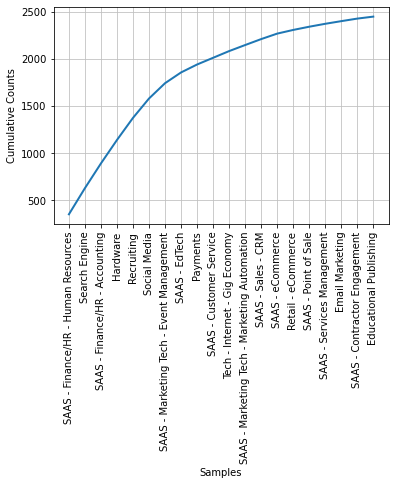

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [54]:
# this plots a cumulative frequency plot of the 50 most used words 
fdist.plot(20, cumulative=True)

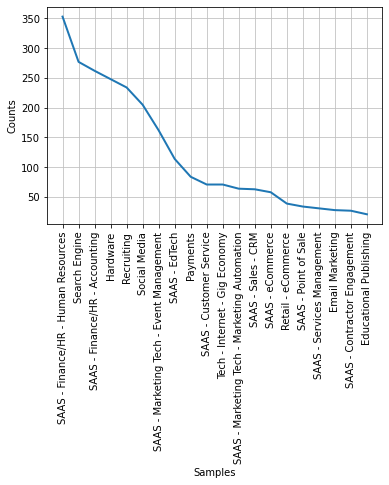

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [52]:
# this plots a regular plot of the most used words, showing word count
fdist.plot(20)

In [55]:
fdist.hapaxes() #looks at rare words

['Telecommunications', 'Transportation', 'Real Estate', 'SAAS - Automotive']

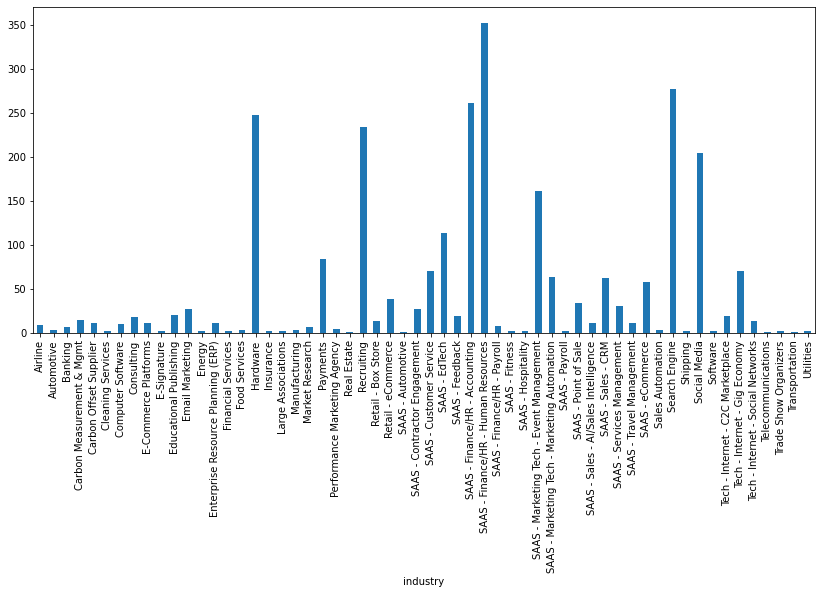

In [57]:
#plotting the number of times each shows up
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,6))
df_pred.groupby('industry').CB_Description.count().plot.bar(ylim=0)
plt.show()

In [59]:
## this is really imbalanced

#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
"""When we encounter such problems, we are bound to have difficulties 
solving them with standard algorithms. Conventional algorithms are often
biased towards the majority class, not taking the data distribution into 
consideration. In the worst case, minority classes are treated as outliers 
and ignored. For some cases, such as fraud detection or cancer prediction, 
we would need to carefully configure our model or artificially balance the 
dataset, for example by undersampling or oversampling each class.

However, in our case of learning imbalanced data, the majority classes 
might be of our great interest. It is desirable to have a classifier that 
gives high prediction accuracy over the majority class, while maintaining 
reasonable accuracy for the minority classes. Therefore, we will leave it 
as it is."""
#that being said, it is still important to icnrease the number of 
#instances of each of these industry classifications, which can only be
#achieved by increasing the training dataset

'When we encounter such problems, we are bound to have difficulties \nsolving them with standard algorithms. Conventional algorithms are often\nbiased towards the majority class, not taking the data distribution into \nconsideration. In the worst case, minority classes are treated as outliers \nand ignored. For some cases, such as fraud detection or cancer prediction, \nwe would need to carefully configure our model or artificially balance the \ndataset, for example by undersampling or oversampling each class.\n\nHowever, in our case of learning imbalanced data, the majority classes \nmight be of our great interest. It is desirable to have a classifier that \ngives high prediction accuracy over the majority class, while maintaining \nreasonable accuracy for the minority classes. Therefore, we will leave it \nas it is.'

### Ok, going to try to work the companies with two industry classifications into the training dataset

In [60]:
df_reduced = df[df['CB Industries'].apply(lambda x: len(x.split(',')) == 2)]

In [62]:
df_reduced['CB Industries'] #only companies left (7118) are those with two industry classifications from CB
df_reduced.shape # (7118, 7)

(7118, 7)

In [63]:
df_reduced.columns

Index(['id', 'name', 'url', 'CB Industries', 'CB Description', 'Keywords',
       'industry'],
      dtype='object')

In [64]:
df_reduced[['CB Industries','name','CB Description']]

,CB Industries,name,CB Description
2,"Consulting, Recruiting",& Friends,& Friends is to find the best qualified candid...
11,"Accounting, Software",1 Accounting Software,Empower Your Accounting with Oneaccouting Soft...
20,"EdTech, Education",10 Minute School,10 Minute School is a web-based educational pl...
40,"Employment, Recruiting",11 Recruitment,11 Recruitment is an employment agency in Pert...
44,"Consulting, Human Resources",121 HR Solutions,121 HR Solutions is an HR Consultancy services...
...,...,...,...
46414,"Search Engine, Software",Zugo Services,"Established in 2008, Zugo was created to bridg..."
46425,"E-Commerce Platforms, Furniture",Zuri Furniture,Zuri Furniture is an online home furnishing st...
46429,"E-Commerce, Social Media",Zurn,Zurn International E-commerce Co. Ltd. is a Ch...
46442,"Hardware, Health Care",Zyken - NightCove,Zyken develops innovative premium wellness pro...


Looking at the CB Industries column, I recognize a lot of the first classifications as words that popped up in the other classification from before (above). Things like "Consulting", Accounting, EdTech, Recruiting (this is in the second position, the first position 'Employment' actually did not show up in the other classification from above.

In [65]:
FreqDist(df_pred['industry']== 'Consulting') 

FreqDist({False: 2682, True: 18})

In [66]:
for desc in df_pred['industry']:
    if 'Recruiting' in desc:
        print(desc)

Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting
Recruiting

A good idea here would be to write a quick for loop that checks if the first industry classification in the pair of classifications is present in the original list (where there was only one industry and we can be sure that this is the correct classification).

What we are attempting to do is match the formatting here to what we established before (and as seen in the Industry Taxonomy slide from the original excel.

So the for loop will check the first industry and will adopt the old formatting for this company. If there is not a match, it will then check the second industry and will adopt the old formatting for this company if there is a match.

In [ ]:



# df_train is concat of df_reduced and TrainingData
for first in range(len(df_reduced)): #loop through length of df_reduced
    #loop through length of TrainingData starting where df_reduced left off
    for other in range(len(df_reduced),len(df_reduced)+len(TrainingData)): 
        #if value from df_train[first] is in df_train[other] (like 'Point of Sale' in 'SAAS - Point of Sale') AND the first thing is smaller than the other thing AND 'SAAS' is not in the first thing, then...
        if df_train['industry'][first] in df_train['industry'][other] and len(df_train['industry'][other])>len(df_train['industry'][first]) and 'SAAS' not in df_train['industry'][first]: 
            #overwrite the df_train['industry'][first] value with the value of the 'other' 
            df_train['industry'][first] = df_train['industry'][other]
            

In [76]:
ind_sub_3 = find_companies(df_reduced, 'CB Industries', 2)
len(ind_sub_3)
ind_sub_3

[['Consulting', ' Recruiting'],
 ['Accounting', ' Software'],
 ['EdTech', ' Education'],
 ['Employment', ' Recruiting'],
 ['Consulting', ' Human Resources'],
 ['Search Engine', ' Travel'],
 ['Consumer', ' Payments'],
 ['Recruiting', ' Software'],
 ['Search Engine', ' Semantic Search'],
 ['Event Management', ' Information Technology'],
 ['Social Media', ' Social Network'],
 ['Accounting', ' Human Resources'],
 ['Accounting', ' Consulting'],
 ['Human Resources', ' Information Technology'],
 ['Human Resources', ' Online Portals'],
 ['EdTech', ' Education'],
 ['Public Relations', ' Social Media'],
 ['Payments', ' Software'],
 ['Recruiting', ' Training'],
 ['Customer Service', ' Software'],
 ['Hardware', ' Software'],
 ['Hardware', ' Software'],
 ['EdTech', ' Education'],
 ['E-Commerce Platforms', ' Online Forums'],
 ['Human Resources', ' Information Technology'],
 ['Consulting', ' Recruiting'],
 ['Human Resources', ' Software'],
 ['Social Media', ' Software'],
 ['Reputation', ' Social Medi

In [79]:
#loops through the range of ind_sub_3, which is 7118
for company in range(len(ind_sub_3)):
    #loops through each key in the industry_to_id dictionary of keys
    for key in industry_to_id.keys():
        #first looking for the first industry in the pair
        if ind_sub_3[company][0] in key and len(key)>len(ind_sub_3[company][0]) and 'SAAS' not in ind_sub_3[company][0]:
            df_reduced.loc[company,'CB Industries'] = key
        elif ind_sub_3[company][1] in key and len(key)>len(ind_sub_3[company][1]) and 'SAAS' not in ind_sub_3[company][1]:
            df_reduced.loc[company,'CB Industries'] = key

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
